<a href="https://colab.research.google.com/github/f1shstyxx/DS_capstone/blob/main/Project_3_LLM/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3 - Supervised Learning for Text Summarization

## Business Understanding

### Background

### Dataset Details

### Project Goals

### Project Considerations

## Data Understanding

In [29]:
!pip install mlflow
!pip install evaluate
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=6cf590312e5238a00998dfda2398b9f969529f82e38c2d648a605daeae257729
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [4]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, \
  accuracy_score, ConfusionMatrixDisplay
from transformers import BertTokenizer, EncoderDecoderModel, TrainingArguments,\
  Trainer, DataCollatorForSeq2Seq
import transformers
from transformers import EarlyStoppingCallback
import mlflow
import mlflow.transformers
import evaluate

# set random seed for reproducibility
def set_seed(seed_value=42):
  random.seed(seed_value)
  np.random.seed(seed_value)
  os.environ['PYTHONHASHSEED'] = str(seed_value)

set_seed()

In [5]:
# install hugging face
# !pip install datasets

In [6]:
# load samsum dataset
from datasets import load_dataset

start_time = time.time()

dataset = load_dataset('knkarthick/samsum')

end_time = time.time()
print(f"Dataset loaded in {(end_time - start_time)/60:.2f} minutes")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

validation.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Dataset loaded in 0.08 minutes


In [7]:
print(f"Details of samsum dataset:\n")
print(dataset)

Details of samsum dataset:

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
})


In [8]:
# print first line from train section of dataset

print(dataset['train'][0])

{'id': '13818513', 'dialogue': "Amanda: I baked  cookies. Do you want some?\nJerry: Sure!\nAmanda: I'll bring you tomorrow :-)", 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}


In [9]:
# convert train, validation and test datasets to dataframes for EDA
# pandas dfs are better for quick exploration than Hugging Face datasets
# hugging face dataset objects are good for modeling, but less flexible for:
# describe(), filtering, plotting, sample inspection

df_train = pd.DataFrame(dataset['train'])
print(df_train.head())

df_val = pd.DataFrame(dataset['validation'])
print(df_val.head())

df_test = pd.DataFrame(dataset['test'])
print(df_test.head())

         id                                           dialogue  \
0  13818513  Amanda: I baked  cookies. Do you want some?\nJ...   
1  13728867  Olivia: Who are you voting for in this electio...   
2  13681000  Tim: Hi, what's up?\nKim: Bad mood tbh, I was ...   
3  13730747  Edward: Rachel, I think I'm in ove with Bella....   
4  13728094  Sam: hey  overheard rick say something\nSam: i...   

                                             summary  
0  Amanda baked cookies and will bring Jerry some...  
1  Olivia and Olivier are voting for liberals in ...  
2  Kim may try the pomodoro technique recommended...  
3  Edward thinks he is in love with Bella. Rachel...  
4  Sam is confused, because he overheard Rick com...  
         id                                           dialogue  \
0  13817023  A: Hi Tom, are you busy tomorrow’s afternoon?\...   
1  13716628  Emma: I’ve just fallen in love with this adven...   
2  13829420  Jackie: Madison is pregnant\nJackie: but she d...   
3  138196

### Text Exploration
Analyze the characteristics of the dialogues and summaries

In [10]:
# train df basic info and describe
print(df_train.info())
print(df_train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14732 entries, 0 to 14731
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        14732 non-null  object
 1   dialogue  14731 non-null  object
 2   summary   14732 non-null  object
dtypes: object(3)
memory usage: 345.4+ KB
None
              id                                           dialogue  \
count      14732                                              14731   
unique     14732                                              14255   
top     13729017  Jimmy: Hey, guess what? My car's completely ka...   
freq           1                                                  4   

                                                  summary  
count                                               14732  
unique                                              14730  
top     Seth's pet Oreo that he got when he was 10 is ...  
freq                                                    2  

In [11]:
# length of train df
print(f"Length of train df: {len(df_train)}")

Length of train df: 14732


In [ ]:
# remove dialogues with fewer than 10 words
min_dialogue_length = 10

def is_long_enough(example):
  return len(example['dialogue'].split()) >= min_dialogue_length

# apply filter to each dataset split
dataset['train'] = dataset['train'].filter(is_long_enough)
dataset['validation'] = dataset['validation'].filter(is_long_enough)
dataset['test'] = dataset['test'].filter(is_long_enough)

In [12]:
# text length analysis
# analysis will include speaker names

# create a new column 'dialogue_length' in df_train by taking 'dialogue' column and splitting the string and finding its length
df_train['dialogue_length'] = df_train['dialogue'].apply(lambda x: len(str(x).split()))

# calculate statistics of dialogue lengths
print("----- Dialogue Length Statistics -----")
print(f"\nAverage dialogue length: {df_train['dialogue_length'].mean():.2f} words")
print(f"\nMedian dialogue length: {df_train['dialogue_length'].median():.2f} words")
print(f"\nMinimum dialogue length: {df_train['dialogue_length'].min()} words")
print(f"\nMaximum dialogue length: {df_train['dialogue_length'].max()} words")

----- Dialogue Length Statistics -----

Average dialogue length: 93.79 words

Median dialogue length: 73.00 words

Minimum dialogue length: 1 words

Maximum dialogue length: 803 words


In [13]:
# create new column 'summary_length' in df_train by taking 'summary' column and splitting the string and finding its length
df_train['summary_length'] = df_train['summary'].apply(lambda x: len(str(x).split()))

# calculate statistics of summary lengths
print("----- Summary Length Statistics -----")
print(f"\nAverage summary length: {df_train['summary_length'].mean():.2f} words")
print(f"\nMedian summary length: {df_train['summary_length'].median():.2f} words")
print(f"\nMinimum summary length: {df_train['summary_length'].min()} words")
print(f"\nMaximum summary length: {df_train['summary_length'].max()} words")

----- Summary Length Statistics -----

Average summary length: 20.32 words

Median summary length: 18.00 words

Minimum summary length: 1 words

Maximum summary length: 64 words


In [14]:
# check for missing values
print(f"Missing values in df_train:\n")
print(df_train.isnull().sum())

print(f"\nMissing values in df_validation:\n")
print(df_val.isnull().sum())

print(f"\nMissing values in df_test:\n")
print(df_test.isnull().sum())

Missing values in df_train:

id                 0
dialogue           1
summary            0
dialogue_length    0
summary_length     0
dtype: int64

Missing values in df_validation:

id          0
dialogue    0
summary     0
dtype: int64

Missing values in df_test:

id          0
dialogue    0
summary     0
dtype: int64


In [15]:
# drop row from df_train with missing value in dialogue column
df_train = df_train.dropna(subset=['dialogue'])
print(f"Missing values in df_train:\n")
print(df_train.isnull().sum())
print(f"\nLength of train df: {len(df_train)}")

Missing values in df_train:

id                 0
dialogue           0
summary            0
dialogue_length    0
summary_length     0
dtype: int64

Length of train df: 14731


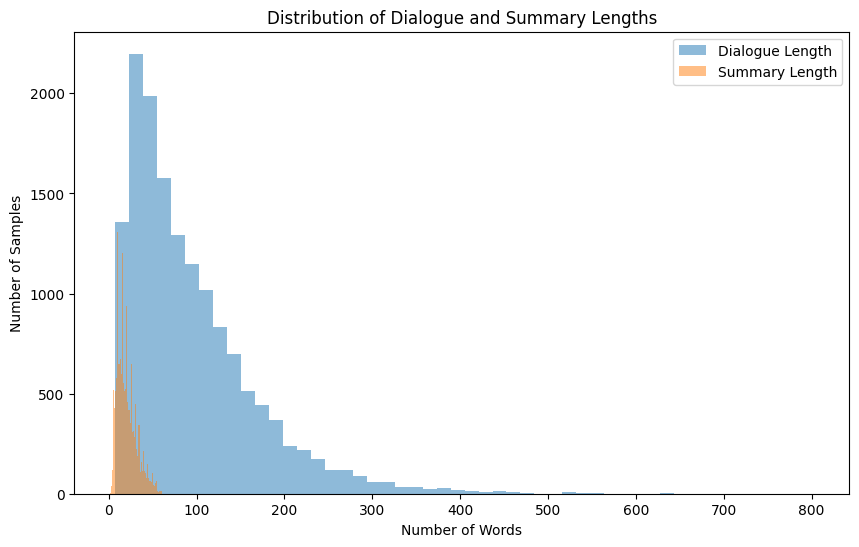

In [16]:
# plot dialogue vs summary lengths for df_train
plt.figure(figsize=(10, 6))
plt.hist(df_train['dialogue_length'], bins=50, alpha=0.5, label='Dialogue Length')
plt.hist(df_train['summary_length'], bins=50, alpha=0.5, label='Summary Length')
plt.xlabel('Number of Words')
plt.ylabel('Number of Samples')
plt.title('Distribution of Dialogue and Summary Lengths')
plt.legend()
plt.show()

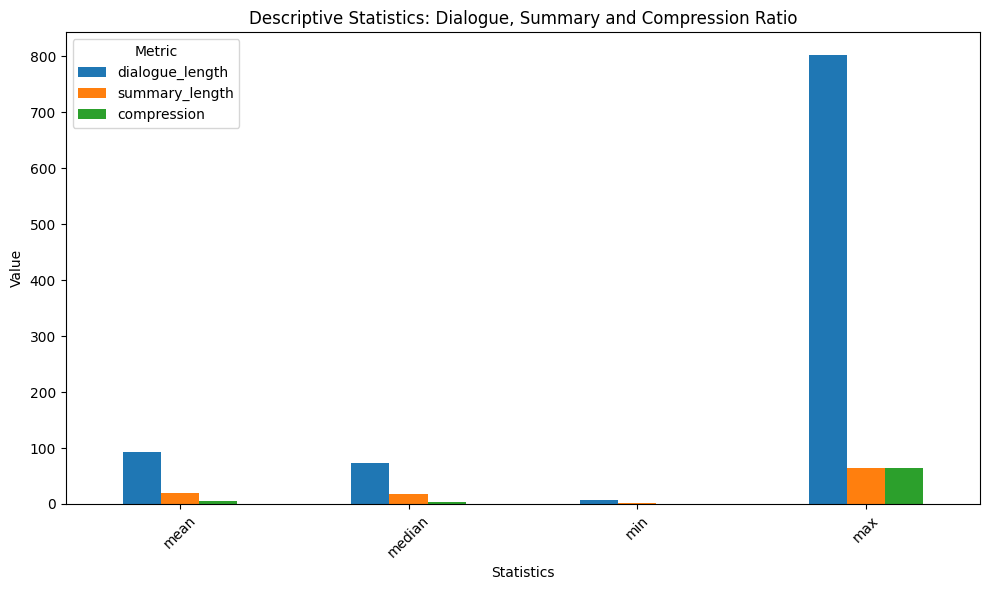

In [17]:
# plot dialogue, summary, and compression statistics for df_train
df_train['compression'] = df_train['dialogue_length'] / df_train['summary_length']
stats = df_train[['dialogue_length', 'summary_length', 'compression']].agg(['mean', 'median', 'min', 'max']).round(2).T

# plot statistics
stats.T.plot(kind='bar', figsize=(10,6))
plt.title('Descriptive Statistics: Dialogue, Summary and Compression Ratio')
plt.xlabel('Statistics')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

In [18]:
# examples of dialogue and summary from df_train
print(f"\nDialogue:\n{df_train['dialogue'][1]}")
print(f"\nSummary:\n{df_train['summary'][1]}")

print(f"\nDialogue:\n{df_train['dialogue'][1000]}")
print(f"\nSummary:\n{df_train['summary'][1000]}")

print(f"\nDialogue:\n{df_train['dialogue'][10000]}")
print(f"\nSummary:\n{df_train['summary'][10000]}")


Dialogue:
Olivia: Who are you voting for in this election? 
Oliver: Liberals as always.
Olivia: Me too!!
Oliver: Great

Summary:
Olivia and Olivier are voting for liberals in this election. 

Dialogue:
Ann: Do you have plans for the holidays this year?
Mary: Well we thought of going for a hike somewhere beautiful
Mary: and you?
Ann: We talked about it last night and we thought maybe you would like to do sth together?
Mary: Why not
Mary: just remember that we're outdoorsy people :D
Ann: I know, but you're not even considering a nice beach somewhere?
Mary: weeeeell, that's not really us, you know?
Mary: we prefer tents and hiking boots to bikinis and sunscreen ;)
Ann: I see.
Ann: I'm not sure I'm ready for a longer hike but maybe we could go somewhere like that for a weekend so I can try it?
Mary: That would be great!
Mary: I'm sure you'll love it just like we do :)
Ann: the idea of spending you time in the woods sure is romantic, but i'm not sure I'll remember that when bugs qill be ea

## Data Preparation

Prep data for input to BERT model
* implement appropriate tokenization
* create training and validation splits
* build data loaders for efficient model training

In [19]:
# initialize tokenizer
# converts input dialogue into token IDs for the encoder
# converts target summary into token IDs for the decoder
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAX_INPUT_LENGTH = 512
MAX_TARGET_LENGTH = 64

# define tokenize function
def tokenize_function(batch):

  # tokenize input dialogue
  inputs = tokenizer(
      batch['dialogue'],
      padding='max_length',
      truncation=True,
      max_length = MAX_INPUT_LENGTH,
  )

  # tokenize target summary
  with tokenizer.as_target_tokenizer():
    labels = tokenizer(
        batch['summary'],
        padding='max_length',
        truncation=True,
        max_length=MAX_TARGET_LENGTH,
  )

  # attach labels to inputs
  inputs['labels'] = labels['input_ids']
  return inputs

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
# tokenize train, validation, and test datasets

start_time = time.time()

# Remove examples with None in 'dialogue' or 'summary'
dataset['train'] = dataset['train'].filter(lambda x: x['dialogue'] is not None and x['summary'] is not None)

tokenized_train = dataset['train'].map(tokenize_function, batched=True)
tokenized_val = dataset['validation'].map(tokenize_function, batched=True)
tokenized_test = dataset['test'].map(tokenize_function, batched=True)

end_time = time.time()
print(f"Tokenization time: {(end_time - start_time)/60:.2f} minutes")

# Tokenization time: 50 sec on 7/25/25

Filter:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Tokenization time: 0.65 minutes


In [21]:
# load a BERT2BERT pre-trained model (encoder-decoder)
# use patrickvonplaten/bert2bert-cnn_dailymail-fp16 as a BERT2BERT model fine-tuned on CNN/DailyMail
# encoder and decoder both use bert-case-uncased
# bert-case-uncased is a commonly used pretrained BERT model from the original BERT paper

model = EncoderDecoderModel.from_pretrained('patrickvonplaten/bert2bert-cnn_dailymail-fp16')

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/992M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/992M [00:00<?, ?B/s]

Some weights of the model checkpoint at patrickvonplaten/bert2bert-cnn_dailymail-fp16 were not used when initializing EncoderDecoderModel: ['decoder.bert.pooler.dense.bias', 'decoder.bert.pooler.dense.weight']
- This IS expected if you are initializing EncoderDecoderModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EncoderDecoderModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
# configure the model for the summarization task

# start of decoding, for BERT based decoders, CLS is used
model.config.decoder_start_token_id = tokenizer.cls_token_id

# end of sequence token, SEP used for BERT
model.config.eos_token_id = tokenizer.sep_token_id

# padding for batches
model.config.pad_token_id = tokenizer.pad_token_id

# ensures encoder and decoder share the same vocab size
model.config.vocab_size = model.config.encoder.vocab_size

## Modeling

In [23]:
# set up training arguments

training_args = TrainingArguments(
    # core argument
    output_dir="./bert2bert_samsum",    # save model checkpoints, logs, etc.
    save_steps=500,         # save a checkpoint every 500 steps, for recovery or versioning
    save_total_limit=2,     # keep only the last 2 saved models
    logging_steps=500,      # log training loss and metrics every 500 steps
    do_train=True,          # enable training
    do_eval=True,           # enable eval during training on eval dataset
    do_predict=True,        # make predictions after training

    # training configuration
    per_device_train_batch_size=4,  # batch size per device for training
    per_device_eval_batch_size=4,   # batch size per device for evaluation
    num_train_epochs=3,             # number of times the model will see the full dataset
    learning_rate=5e-5,             # how quickly the model updates weights
    lr_scheduler_type="linear",     # how learning rate changes over time
    # linear gradually decreases, or cosine, constant
    warmup_steps=500,               # num of steps to slowly ramp up learning rate
    # before stabilizing. helps avoid bad initial updates

    # performance optimization
    fp16=True,              # reduce memory usage and speed up training

    # monitoring and model selection
    metric_for_best_model="rougeL",
    greater_is_better=True,            # True if higher metric values are better (ROUGE)
    report_to="tensorboard",  # enables TensorBoard logging

)

# 2. Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# 3. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

/tmp/ipython-input-23-2558440241.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [24]:
start_time = time.time()

mlflow.set_experiment("BERT2BERT SAMSum")

with mlflow.start_run():
    mlflow.log_param("model", "bert2bert-cnn_dailymail-fp16")
    mlflow.log_param("epochs", 3)
    mlflow.log_param("batch_size", 4)

    # Start training
    trainer.train()

    # Log final model and tokenizer
    model.save_pretrained("./bert2bert_samsum_final")
    tokenizer.save_pretrained("./bert2bert_samsum_final")

    mlflow.log_artifacts("./bert2bert_samsum_final", artifact_path="model")

end_time = time.time()
print(f"Training time: {(end_time - start_time)/60:.2f} minutes")

# training time: 51 minutes on 7/25/25
# training time: 42 minutes on 7/26/25 w/ 3 epochs
# training time: 71 min on 7/26/25 w/ 3 epochs (from MLflow)
# training time: 66.8 min on 7/27/25 w/ 5 epochs
# training time: 67 min on 7/27/25 w/ 10 epochs
# training time: 40 min on 7/27/25 w/ 3 epochs
# training time: 47 min on 7/29/25 w/ 3 epochs

2025/07/29 15:56:26 INFO mlflow.tracking.fluent: Experiment with name 'BERT2BERT SAMSum' does not exist. Creating a new experiment.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Step,Training Loss
500,2.244900
1000,1.008300
1500,0.964900
2000,0.969900
2500,0.913100
3000,0.924100
3500,0.901600
4000,0.782600
4500,0.685600
5000,0.701400


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3685: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/model

Training time: 46.79 minutes


In [25]:
# reload model and tokenizer
import torch

tokenizer = BertTokenizer.from_pretrained("./bert2bert_samsum_final")
model = EncoderDecoderModel.from_pretrained("./bert2bert_samsum_final")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [26]:
start_time = time.time()

# Redefine training arguments (can extend epochs)
training_args = TrainingArguments(
    output_dir="./bert2bert_samsum",
    save_steps=500,
    save_total_limit=2,
    logging_steps=500,
    do_train=True,
    do_eval=True,
    do_predict=True,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,  # increase this for additional epochs
    learning_rate=5e-5,
    lr_scheduler_type="linear",
    warmup_steps=500,
    fp16=True,
    metric_for_best_model="rougeL",
    greater_is_better=True,
    report_to="tensorboard"
)

# Redefine data collator and trainer
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,  # should be already in memory
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer.train()

end_time = time.time()
print(f"Training time: {(end_time - start_time)/60:.2f} minutes")

# training time: 67 min on 7/27/25 w/ 10 epochs

/tmp/ipython-input-26-2182294910.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Step,Training Loss
500,0.464800
1000,0.451400
1500,0.465300
2000,0.489500
2500,0.474400
3000,0.500900
3500,0.499200
4000,0.410700
4500,0.340500
5000,0.363800


/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/usr/local/lib/python3.11/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no 

Training time: 78.29 minutes


## Evaluation

use ROUGE (Recall-Oriented Understudy for Gisting Evaluation) to compare the overlap between generated summaries and reference summaries.

In [27]:
from torch.utils.data import Subset

# Get 5 evenly spaced indices from the test set
# indices = np.linspace(0, len(dataset['test']) - 1, num=5, dtype=int)

# Cast each to Python int explicitly
# raw_samples = [dataset['test'][int(i)] for i in indices]

# Tokenize them manually
inputs = tokenizer(
    [sample['dialogue'] for sample in dataset['test']],
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512
).to(model.device)

# Generate summaries
output_ids = model.generate(
    **inputs,
    max_length=64,                # already used
    min_length=20,                # optional, for preventing too short outputs
    length_penalty=1.2,           # >1.0 discourages long outputs
    num_beams=10,                  # better than greedy (you’re probably using greedy now)
    early_stopping=True,          # stop when an EOS token is reached
    no_repeat_ngram_size=3        # prevents repetition
)

# Decode
decoded_preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
decoded_labels = [sample['summary'] for sample in dataset['test']]

# Show prediction vs. reference
for i in range(len(decoded_preds)):
    print(f"\n--- Example {i+1} ---")
    print(f"Dialogue:\n{dataset['test'][i]['dialogue']}")
    print(f"\nGenerated Summary:\n{decoded_preds[i]}")
    print(f"\nReference Summary:\n{decoded_labels[i]}")


--- Example 1 ---
Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Generated Summary:
betty is looking for betty's number. amanda doesn't know her well. hannah texted betty last time they were at the park together.

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

--- Example 2 ---
Dialogue:
Sam: hi, i need a help
Sarah fashion: hello how can i help?
Sam: Actually i was looking for a nice black dress for my wife, i mean i dont want the in-store product..
Sarah fashion: Yes sir, we make dresses on order as per customer requirements.
Sam: yeah i saw that option on the w

In [30]:
start_time = time.time()

rouge = evaluate.load("rouge")

# Clean strings
decoded_preds_clean = [pred.strip() for pred in decoded_preds]
decoded_labels_clean = [label.strip() for label in decoded_labels]

# Compute ROUGE scores
results = rouge.compute(predictions=decoded_preds_clean, references=decoded_labels_clean)
for key, value in results.items():
    print(f"{key}: {value:.4f}")


end_time = time.time()
print(f"Evaluation time: {(end_time - start_time)/60:.2f} minutes")

rouge1: 0.4264
rouge2: 0.1969
rougeL: 0.3476
rougeLsum: 0.3457
Evaluation time: 0.02 minutes


In [33]:
# batch based summary generation

def generate_summaries_in_batches(dialogues, batch_size=8):
    generated = []
    model.eval()  # switch to inference mode

    for i in range(0, len(dialogues), batch_size):
        batch = dialogues[i:i + batch_size]

        inputs = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(model.device)

        with torch.no_grad():
            output_ids = model.generate(
                **inputs,
                max_length=64,
                min_length=20,
                num_beams=10,
                no_repeat_ngram_size=3,
                early_stopping=True
            )

        batch_summaries = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        generated.extend(batch_summaries)

        # optional: free GPU memory between batches
        torch.cuda.empty_cache()

    return generated

# Get test dialogues
test_dialogues = list(dataset['test']['dialogue'])

# Generate summaries safely
generated_summaries = generate_summaries_in_batches(test_dialogues, batch_size=2)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 17.38 MiB is free. Process 16937 has 22.14 GiB memory in use. Of the allocated memory 21.50 GiB is allocated by PyTorch, and 415.51 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

running into CUDA out of memory because GPU is fully saturdaed

try restarting runtime to fully clear memory. Then only run import torch, load tokenizer/model, run generated_summaries_in_batches

In [34]:
# visualize test dialogue vs summary vs generated summary lengths

# Compute lengths
test_dialogue_lengths = [len(d.split()) for d in dataset['test']['dialogue']]
test_ref_summary_lengths = [len(s.split()) for s in dataset['test']['summary']]
test_gen_summary_lengths = [len(s.split()) for s in generated_summaries]  # model outputs

# Plot
plt.figure(figsize=(10, 6))
plt.hist(test_dialogue_lengths, bins=50, alpha=0.4, label='Dialogue Length')
plt.hist(test_ref_summary_lengths, bins=50, alpha=0.5, label='Reference Summary Length')
plt.hist(test_gen_summary_lengths, bins=50, alpha=0.6, label='Generated Summary Length')
plt.xlabel('Number of Words')
plt.ylabel('Number of Samples')
plt.title('Test Set: Dialogue vs. Summary vs. Generated Summary Lengths')
plt.legend()
plt.show()

NameError: name 'generated_summaries' is not defined

In [ ]:
# Compute word lengths
test_dialogue_length = [len(d.split()) for d in dataset['test']['dialogue']]
test_summary_length = [len(s.split()) for s in dataset['test']['summary']]
test_generated_length = [len(s.split()) for s in generated_summaries]

# Compute compression ratios
test_compression_ref = [d/s if s != 0 else 0 for d, s in zip(test_dialogue_length, test_summary_length)]
test_compression_gen = [d/s if s != 0 else 0 for d, s in zip(test_dialogue_length, test_generated_length)]

In [ ]:
# visualize test dialogue vs summary vs generated summary lengths and compression ratios
df_stats = pd.DataFrame({
    "Dialogue Length": test_dialogue_length,
    "Reference Summary Length": test_summary_length,
    "Generated Summary Length": test_generated_length,
    "Compression (Reference)": test_compression_ref,
    "Compression (Generated)": test_compression_gen
})

# Aggregate statistics
summary_stats = df_stats.agg(['mean', 'median', 'min', 'max']).round(2).T

summary_stats.plot(kind='bar', figsize=(12, 6))
plt.title('Test Set: Dialogue, Summary, and Compression Statistics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Statistic')
plt.tight_layout()
plt.show()

In [ ]:
# load google/pegasus-samsum

from transformers import PegasusTokenizer, PegasusForConditionalGeneration

model_name = "google/pegasus-cnn_dailymail"

tokenizer = PegasusTokenizer.from_pretrained(model_name)
model_2 = PegasusForConditionalGeneration.from_pretrained(model_name)


# Notes on model performance
# - Model captures structure of conversations well.
# - Struggles with informal/abrupt phrases or very long dialogues.
# - Sometimes over-summarizes or paraphrases too freely.

# Conclusion